In [250]:
import numpy as np
import matplotlib.pyplot as plt
import aotools
import numbaLib 
from numbaLib import bilinear_interp
from numbaLib import zoom
# from numbaLib import bin_img

In [251]:
import multiprocessing
N_CPU = multiprocessing.cpu_count()
from threading import Thread

# python3 has queue, python2 has Queue
try:
    import queue
except ImportError:
    import Queue as queue

import numpy
import numba

def bin_img(input_img, bin_size, binned_img, threads=None):
    N_CPU = 4
    if threads is None:
        threads = N_CPU

    n_rows = binned_img.shape[0]

    Ts = []
    for t in range(threads):
        Ts.append(Thread(target=bin_img_numba,
                         args=(
                             input_img, bin_size, binned_img,
                             numpy.array([int(t * n_rows / threads), int((t + 1) * n_rows / threads)]),
                         )
                         ))
        Ts[t].start()

    for T in Ts:
        T.join()

    return binned_img

@numba.jit(nopython=True, nogil=True)
def bin_img_numba(imgs, bin_size, new_img, row_indices):
    # loop over each element in new array
    for i in range(row_indices[0], row_indices[1]):
        x1 = i * bin_size

        for j in range(new_img.shape[1]):
            y1 = j * bin_size
            new_img[i, j] = 0

            # loop over the values to sum
            for x in range(bin_size):
                for y in range(bin_size):
                    new_img[i, j] += imgs[x1 + x, y1 + y]




In [252]:
class phaseScreen(object):
    # Using Stategy Pattern to generate the phase screens using and 
    # arbitrary generator function. E.g. Zernike, KL, Kolmogorov, etc.
    def __init__(self, N, strategy, generatorParameters):
        self.N = N
        self.generator = strategy
        self.generatorParameters = generatorParameters
        # Placeholder Attributes
        self.scrn = np.zeros((N,N))
    def setParams(self, **kwargs):
        self.generatorParameters = kwargs
    def generate(self, **kwargs):
        self.scrn = self.generator.generate(self.N, **self.generatorParameters)
        return self.scrn
    def decompose(self, type="zernike",nModes=50):
        if type == "zernike":
            mask = aotools.circle(self.N//2,self.N)
            A = mask*self.scrn
            Z = aotools.zernikeArray(nModes, self.N)
            z = np.array([np.trace(Zj.conj().T @ A ) for Zj in Z]) /self.N**2
            return z
        else:
            # Generate Error
            raise ValueError("Decomposition type not recognised")

# Generator Interface
class generatorStrategy(object):
    def generate(self, N, **kwargs):
        pass

class finitePhaseScreen(generatorStrategy):
    def generate(self, N, **kwargs):
        # unpack the parameters
        r0 = kwargs['r0']
        delta = kwargs['delta']
        L0,l0 = kwargs['L0'], kwargs['l0']
        subHarmonics = kwargs['subHarmonics']
        if subHarmonics == True:
            screen = aotools.turbulence.phasescreen.ft_sh_phase_screen(r0, N, delta, L0, l0)
        else:
            screen = aotools.turbulence.phasescreen.ft_phase_screen(r0, N, delta, L0, l0)
        return screen



In [253]:
N_p = 2**10
N_f = 2**9

D = 0.7
f = 8.41

wvl = 1550e-9

r0 = 0.15
L0,l0 = 10,0.00001

# sim_size
simPad = 1
fftOversamp = 4

In [254]:
# fov = 2*np.arctan(D/(2*f))
fov_arcsec = 30
fov = np.radians(fov_arcsec/3600)
# fov = 0.000145

D = 0.7

mask = aotools.circle(N_p//2,N_p)-aotools.circle(N_p//2*0.3,N_p)


print('fov',(fov))
sim_size = N_p + 2*simPad

fov 0.0001454441043328608


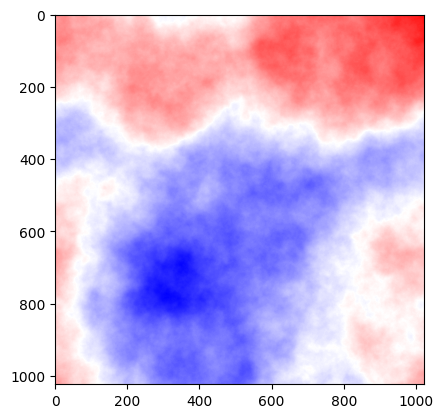

In [255]:
finitePhaseScreenParms = {'r0': r0, 'delta': D/N_p, 'L0': L0, 'l0': l0, 'subHarmonics': True}
phaseScreenGenerator = phaseScreen(N_p, finitePhaseScreen(), finitePhaseScreenParms)

P = phaseScreenGenerator.generate()
plt.imshow(P,cmap='bwr')

In [256]:
FovPxlNo = (np.round(D*fov/wvl)).astype(int)
print(f'FovPxlNo: {FovPxlNo}')
padFOVPxlNo = np.round(FovPxlNo * sim_size/N_p).astype(int)

FFTPadding = N_f * fftOversamp
if FFTPadding < FovPxlNo:
    while FFTPadding < FovPxlNo:
        fftOversamp += 1
        FFTPadding = fftOversamp*N_f
print(f'FFTPadding: {FFTPadding}')

fftInput = np.zeros((FFTPadding,FFTPadding),dtype=complex)
interpCoords = np.linspace(simPad,simPad+N_p, FovPxlNo)


FovPxlNo: 66
FFTPadding: 4096


In [257]:
def interp(P,interpCoords):
    interpArray = np.zeros((interpCoords.size,interpCoords.size),dtype=np.complex128)
    bilinear_interp(P,interpCoords,interpCoords,interpArray)
    return interpArray

In [258]:
phaseInterp = interp(P,interpCoords)
print(f"phaseInterp.shape: {phaseInterp.shape}")

phaseInterp.shape: (66, 66)


In [259]:
scaledMask = zoom(mask,FovPxlNo)
E_fov = np.exp(1j*phaseInterp)*scaledMask

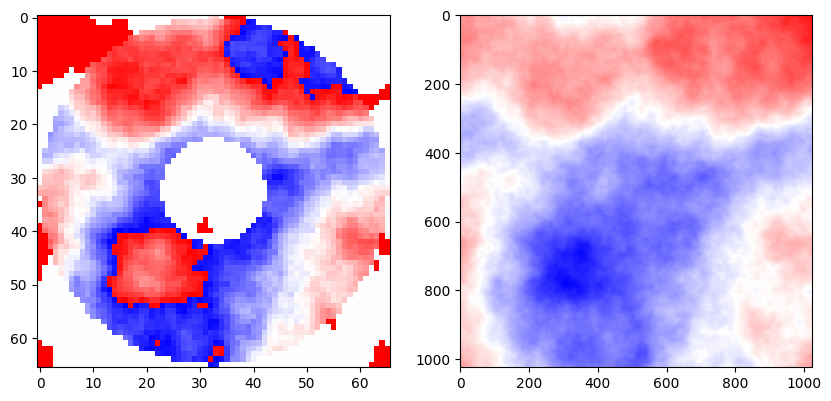

In [260]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(np.angle(E_fov),cmap='bwr')
ax[1].imshow(P,cmap='bwr')

E_focal.shape: (4096, 4096)


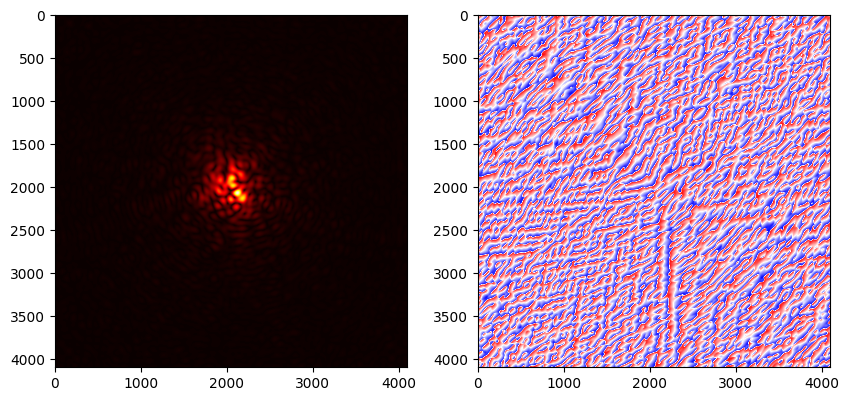

In [261]:

FFTInputArray = np.zeros((FFTPadding,FFTPadding),dtype=np.complex128)
FFTInputArray[:FovPxlNo,:FovPxlNo] = E_fov

E_focal = np.fft.fftshift(np.fft.fft2(FFTInputArray))
print(f"E_focal.shape: {E_focal.shape}")

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(np.abs(E_focal),cmap='hot')
ax[1].imshow(np.angle(E_focal),cmap='bwr')

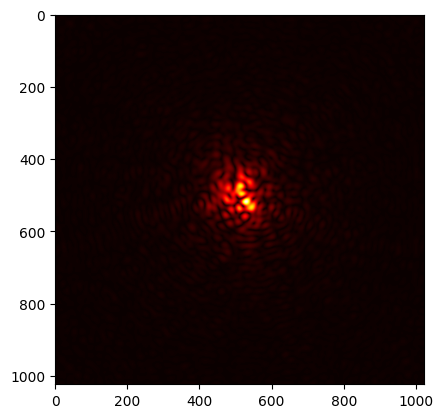

In [262]:

# Resize E_F
E_fp = np.zeros((N_f,N_f),dtype=np.complex128)
E_fp = bin_img(E_focal, fftOversamp, E_fp)

plt.imshow(np.abs(E_fp),cmap='hot')

In [264]:
def effectiveFocalLen(D,fov):
    return D/(2*np.tan(fov/2) )

eff = effectiveFocalLen(D,fov)

focalPlanePixelScale = wvl*eff/(D*N_f)

print(f'focalPlanePixelScale: {focalPlanePixelScale}')

focalPlanePixelScale: 1.0407241182272249e-05
